## Traffic Forecasting Research Plan (Phase 1)
## Model Strategy, Evaluation Metrics, and Selection Criteria

### Objective
To identify the most accurate and robust model for traffic flow forecasting using real-world traffic sensor data. The best model will later feed into EV charging coordination simulations for improving power system resilience.

---

## Modeling Strategy

We will compare **9 models** across 4 categories:

| Category                    | Models |
|----------------------------|--------|
| **Baseline Models**        | Linear Regression, LSTM-only |
| **Published Hybrid Model** | CNN-GRU-LSTM (from literature) |
| **Graph-based Models**     | DCRNN-only, STGCN-only, GraphWaveNet-only |
| **Proposed Hybrid Models** | DCRNN-GRU-LSTM, STGCN-GRU-LSTM, GraphWaveNet-GRU-LSTM |

---

## Model Rationales

**1. Baseline Models**
- *Linear Regression*: Simple, interpretable benchmark.
- *LSTM-only*: Captures temporal patterns without spatial structure.

**2. CNN-GRU-LSTM (Literature Benchmark)**
- Combines CNN (spatial features) + GRU + LSTM (short and long-term temporal dependencies).
- Reproduced from a recent paper for benchmarking.

**3. Graph-based Models**
- *DCRNN*: Diffusion convolution (directed graphs) + RNNs.
- *STGCN*: Chebyshev graph convolution + temporal convolution.
- *GraphWaveNet*: Adaptive graph learning + dilated causal convolutions.

**4. Proposed Hybrid Models**
- Combines graph-based spatial modules with GRU and LSTM layers to leverage deep spatial-temporal dependencies.

---

## Forecasting Horizon

We forecast traffic **72 hours ahead (3 days)** using multi-output models. This helps evaluate short- and medium-term predictive accuracy.

- Models will be trained to predict:
  - The next **12, 24 hours**,
  - And the next **48, 72 hours** ahead.

---

## Evaluation Metrics

We will use **three key metrics** for model comparison:

- **MAPE (Mean Absolute Percentage Error)**: 
  - Interpretable percentage error.
- **RMSE (Root Mean Squared Error)**: 
  - Penalizes larger errors more heavily.
- **MAE (Mean Absolute Error)**: 
  - Stable average error measure.

All models will be evaluated on the same test set using these metrics at both 24h and 72h forecasting horizons.

---

## Model Selection Criteria

Final model will be selected based on:

1. **Lowest RMSE, MAE, and MAPE** on test data.
2. **Spatial consistency**: Station-level errors should not vary drastically.
3. **Generalization ability**: Minimal overfitting (close validation and test performance).
4. **Efficiency** *(secondary)*: Preference for simpler or faster models if performance is tied.

---

## Input Features (Used Across All Models)

To ensure a fair comparison, all 9 models will use the same feature set:

- **Temporal Features**: hour, day, month, weekday, holiday flags.
- **Lag Features**: Flow_lag_1 to Flow_lag_72.
- **Sliding Window Stats**: rolling mean, min, max, std.
- **Cyclical Features**: sine/cosine of time variables.
- **Graph Features**:
  - *DCRNN*: fixed adjacency matrix from CV clustering.
  - *STGCN*: Chebyshev-based graph structure.
  - *GraphWaveNet*: learns the adjacency dynamically.

---

## Summary

- Compare 9 models (baseline, benchmark, graph-based, hybrid).
- Forecast 24h and 72h ahead.
- Use MAPE, RMSE, MAE as evaluation metrics.
- Select best model for downstream EV charging coordination.


In [1]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import lightgbm as lgb

In [3]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [4]:
df. head()

,Timestamp,Station,District,Route,Direction of Travel,Lane Type,Station Length,Samples,% Observed,Total Flow,...,Lane 5 Avg Speed,Lane 6 Flow,Lane 6 Avg Occ,Lane 6 Avg Speed,Lane 7 Flow,Lane 7 Avg Occ,Lane 7 Avg Speed,Lane 8 Flow,Lane 8 Avg Occ,Lane 8 Avg Speed
0,10/01/2024 00:00:00,308512,3,50,W,ML,3.995,197,0,497.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/01/2024 00:00:00,311831,3,5,S,OR,NaN,101,92,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10/01/2024 00:00:00,311832,3,5,S,FR,NaN,101,92,78.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/01/2024 00:00:00,311844,3,5,N,OR,NaN,202,92,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/01/2024 00:00:00,311847,3,5,N,OR,NaN,303,92,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [6]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,Avg Speed,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,64.1,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,NaN,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,NaN,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,NaN,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,NaN,92,303,OR


In [7]:
df.isna().sum()

Timestamp                    0
Station                      0
Route                        0
Direction of Travel          0
Total Flow              303776
Avg Speed              1582594
% Observed                   0
Samples                      0
Lane Type                    0
dtype: int64

In [8]:
df.drop(columns=["Avg Speed"], inplace=True)

In [9]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [10]:
df.isna().sum()

Timestamp                   0
Station                     0
Route                       0
Direction of Travel         0
Total Flow             303776
% Observed                  0
Samples                     0
Lane Type                   0
dtype: int64

In [11]:
df = df[df['Total Flow'].notna()]

In [12]:
df.isna().sum()

Timestamp              0
Station                0
Route                  0
Direction of Travel    0
Total Flow             0
% Observed             0
Samples                0
Lane Type              0
dtype: int64

In [13]:
df.head()

,Timestamp,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
0,10/01/2024 00:00:00,308512,50,W,497.0,0,197,ML
1,10/01/2024 00:00:00,311831,5,S,27.0,92,101,OR
2,10/01/2024 00:00:00,311832,5,S,78.0,92,101,FR
3,10/01/2024 00:00:00,311844,5,N,43.0,92,202,OR
4,10/01/2024 00:00:00,311847,5,N,73.0,92,303,OR


In [14]:
df.dtypes

Timestamp               object
Station                  int64
Route                    int64
Direction of Travel     object
Total Flow             float64
% Observed               int64
Samples                  int64
Lane Type               object
dtype: object

In [15]:
df.duplicated().sum()

0

In [16]:
df.reset_index().duplicated(subset=['Timestamp', 'Station']).sum()

0

In [17]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [18]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [19]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01,308512,50,W,497.0,0,197,ML
2024-10-01,311831,5,S,27.0,92,101,OR
2024-10-01,311832,5,S,78.0,92,101,FR
2024-10-01,311844,5,N,43.0,92,202,OR
2024-10-01,311847,5,N,73.0,92,303,OR


In [20]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [21]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [22]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,TotalFlow_lag_63,TotalFlow_lag_64,TotalFlow_lag_65,TotalFlow_lag_66,TotalFlow_lag_67,TotalFlow_lag_68,TotalFlow_lag_69,TotalFlow_lag_70,TotalFlow_lag_71,TotalFlow_lag_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,312652,99,N,64.0,92,303,OR,0,1,1,...,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0,27.0,497.0
2024-10-01,312689,51,N,601.0,92,395,ML,0,1,1,...,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0,27.0
2024-10-01,312694,51,N,799.0,92,404,ML,0,1,1,...,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0,78.0
2024-10-01,312706,51,N,60.0,92,202,OR,0,1,1,...,23.0,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0,43.0
2024-10-01,312709,51,N,59.0,92,202,FR,0,1,1,...,957.0,23.0,782.0,1042.0,16.0,1042.0,15.0,549.0,1198.0,73.0


In [23]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [24]:
df['Flow_roll_mean_6h'] = df['Total Flow'].rolling(window=6).mean()
df['Flow_roll_std_6h'] = df['Total Flow'].rolling(window=6).std()
df['Flow_roll_max_6h'] = df['Total Flow'].rolling(window=6).max()
df['Flow_roll_min_6h'] = df['Total Flow'].rolling(window=6).min()

In [25]:
for window in [3, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\2328731992.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()
C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\2328731992.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\2328731992.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

In [26]:
df.dropna(inplace=True)

In [27]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\806490332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)


In [28]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_24,Flow_mean_48,Flow_std_48,Flow_min_48,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,1068.0,395.833333,570.838627,3.0,3419.0,435.736111,522.596712,3.0,3419.0,0
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,1068.0,399.458333,568.924516,3.0,3419.0,437.486111,521.544267,3.0,3419.0,0
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,1068.0,404.375000,571.276906,3.0,3419.0,440.069444,522.824677,3.0,3419.0,0
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,1068.0,426.000000,575.736716,3.0,3419.0,443.555556,526.078366,3.0,3419.0,0
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1068.0,376.937500,383.507686,3.0,1525.0,457.500000,529.066225,3.0,3419.0,0


In [29]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\3657398913.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']
C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\3657398913.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']
C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\3657398913.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [30]:
df.dropna(inplace=True)

In [31]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

C:\Users\attafuro\AppData\Local\Temp\ipykernel_16020\3728792865.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])


In [32]:
df.head()

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,...,Flow_max_48,Flow_mean_72,Flow_std_72,Flow_min_72,Flow_max_72,IsHoliday,Flow_CV_12,Flow_CV_24,Flow_CV_48,Flow_CV_72
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01,313344,50,W,190.0,92,202,ML,0,1,1,...,3419.0,435.736111,522.596712,3.0,3419.0,0,0.581854,0.884330,1.442119,1.199342
2024-10-01,313349,50,W,190.0,92,202,ML,0,1,1,...,3419.0,437.486111,521.544267,3.0,3419.0,0,0.648914,0.895621,1.424240,1.192139
2024-10-01,313368,80,W,787.0,100,719,ML,0,1,1,...,3419.0,440.069444,522.824677,3.0,3419.0,0,0.534337,0.827111,1.412740,1.188050
2024-10-01,313386,80,W,1050.0,92,404,ML,0,1,1,...,3419.0,443.555556,526.078366,3.0,3419.0,0,0.530732,0.817180,1.351495,1.186048
2024-10-01,313393,80,E,1064.0,92,505,ML,0,1,1,...,1525.0,457.500000,529.066225,3.0,3419.0,0,0.545745,0.772216,1.017430,1.156429


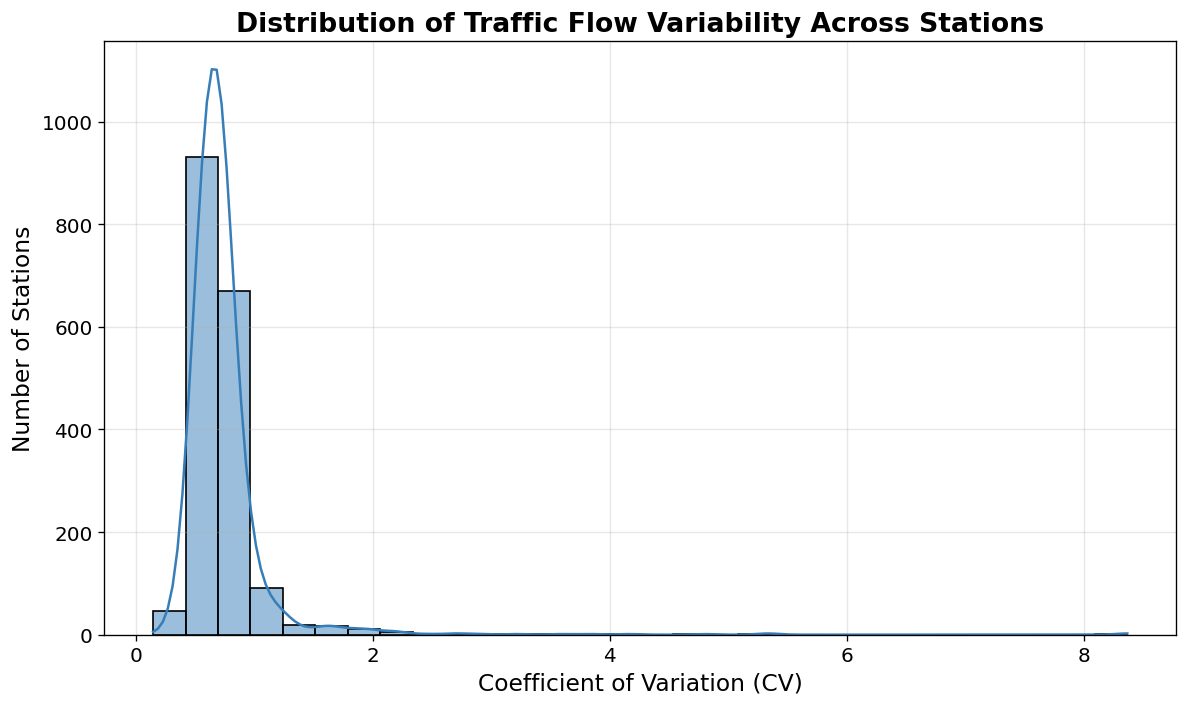

In [33]:
plt.figure(figsize=(10, 6), dpi=120)
sns.histplot(station_stats['CV'], bins=30, kde=True, color="#377eb8", edgecolor="black")

plt.title('Distribution of Traffic Flow Variability Across Stations', fontsize=16, fontweight='bold')
plt.xlabel('Coefficient of Variation (CV)', fontsize=14)
plt.ylabel('Number of Stations', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

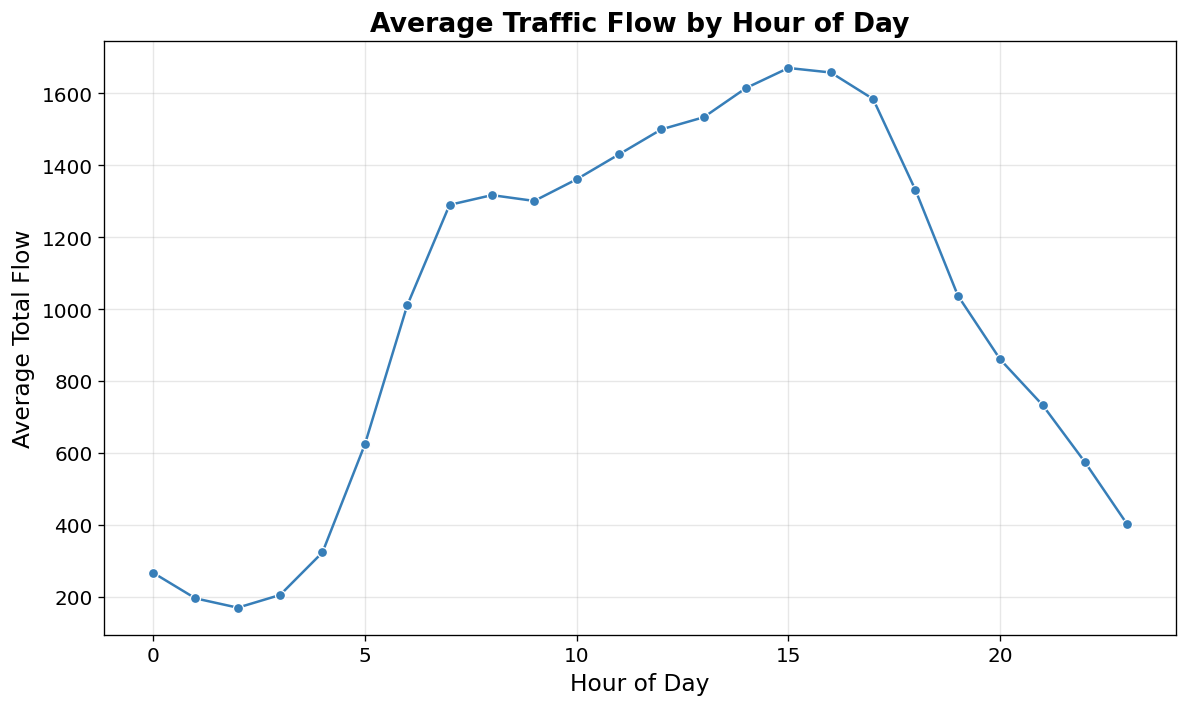

In [34]:
hourly_flow = df.groupby('Hour')['Total Flow'].mean().reset_index()

plt.figure(figsize=(10, 6), dpi=120)
sns.lineplot(data=hourly_flow, x='Hour', y='Total Flow', marker='o', color='#377eb8')

plt.title('Average Traffic Flow by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Total Flow', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

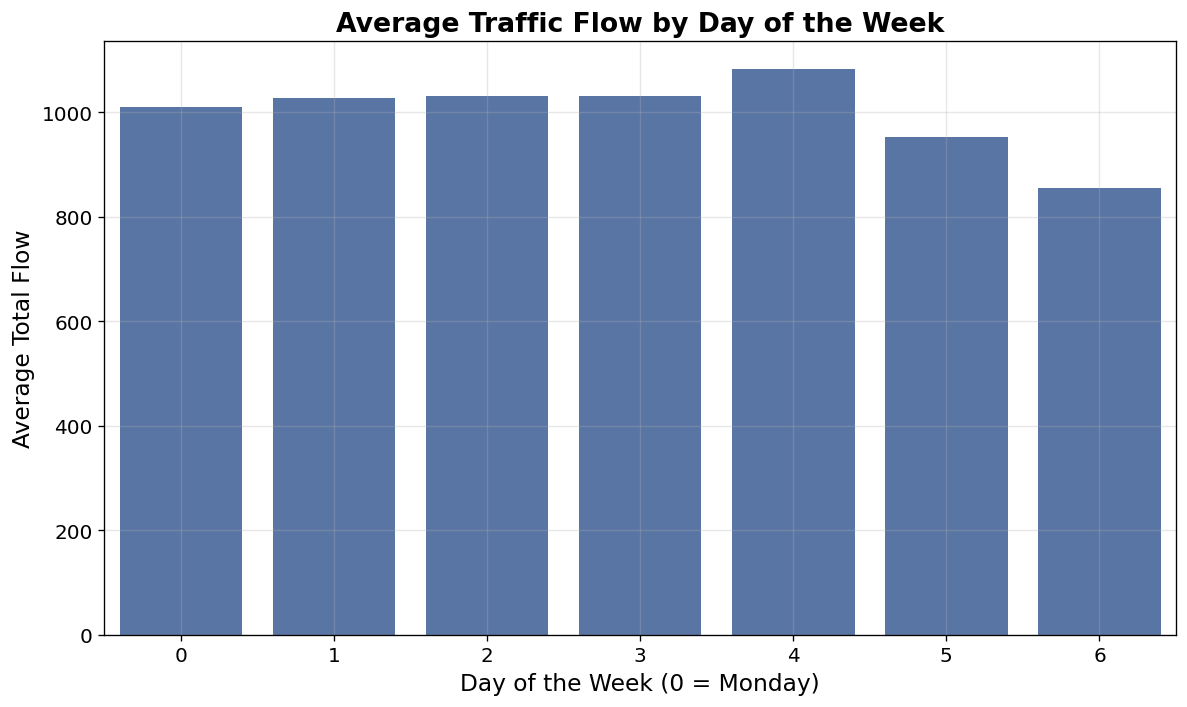

In [35]:
weekday_flow = df.groupby('Weekday')['Total Flow'].mean().reset_index()

# Weekday traffic plot with consistent color and no warning
plt.figure(figsize=(10, 6), dpi=120)
sns.barplot(data=weekday_flow, x='Weekday', y='Total Flow', color="#4c72b0")  # professional muted blue

plt.title('Average Traffic Flow by Day of the Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of the Week (0 = Monday)', fontsize=14)
plt.ylabel('Average Total Flow', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
# High CV stations boxplot
plt.figure(figsize=(12, 6), dpi=120)
sns.boxplot(x='Station', y='Total Flow', data=df[df['Station'].isin(top_high_cv)], color="#4c72b0")

plt.title('Traffic Flow Fluctuations at High-CV Stations', fontsize=16, fontweight='bold')
plt.xlabel('Station ID', fontsize=14)
plt.ylabel('Total Flow (Hourly)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'top_high_cv' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Low CV stations boxplot
plt.figure(figsize=(12, 6), dpi=120)
sns.boxplot(x='Station', y='Total Flow', data=df[df['Station'].isin(top_low_cv)], color="#6baed6")

plt.title('Traffic Flow Fluctuations at Low-CV Stations', fontsize=16, fontweight='bold')
plt.xlabel('Station ID', fontsize=14)
plt.ylabel('Total Flow (Hourly)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
df['IsHoliday'] = df['IsHoliday'].astype('category')
df['Route'] = df['Route'].astype('category')

In [38]:
#  Keep only numeric features
numeric_df = df.select_dtypes(include='number')

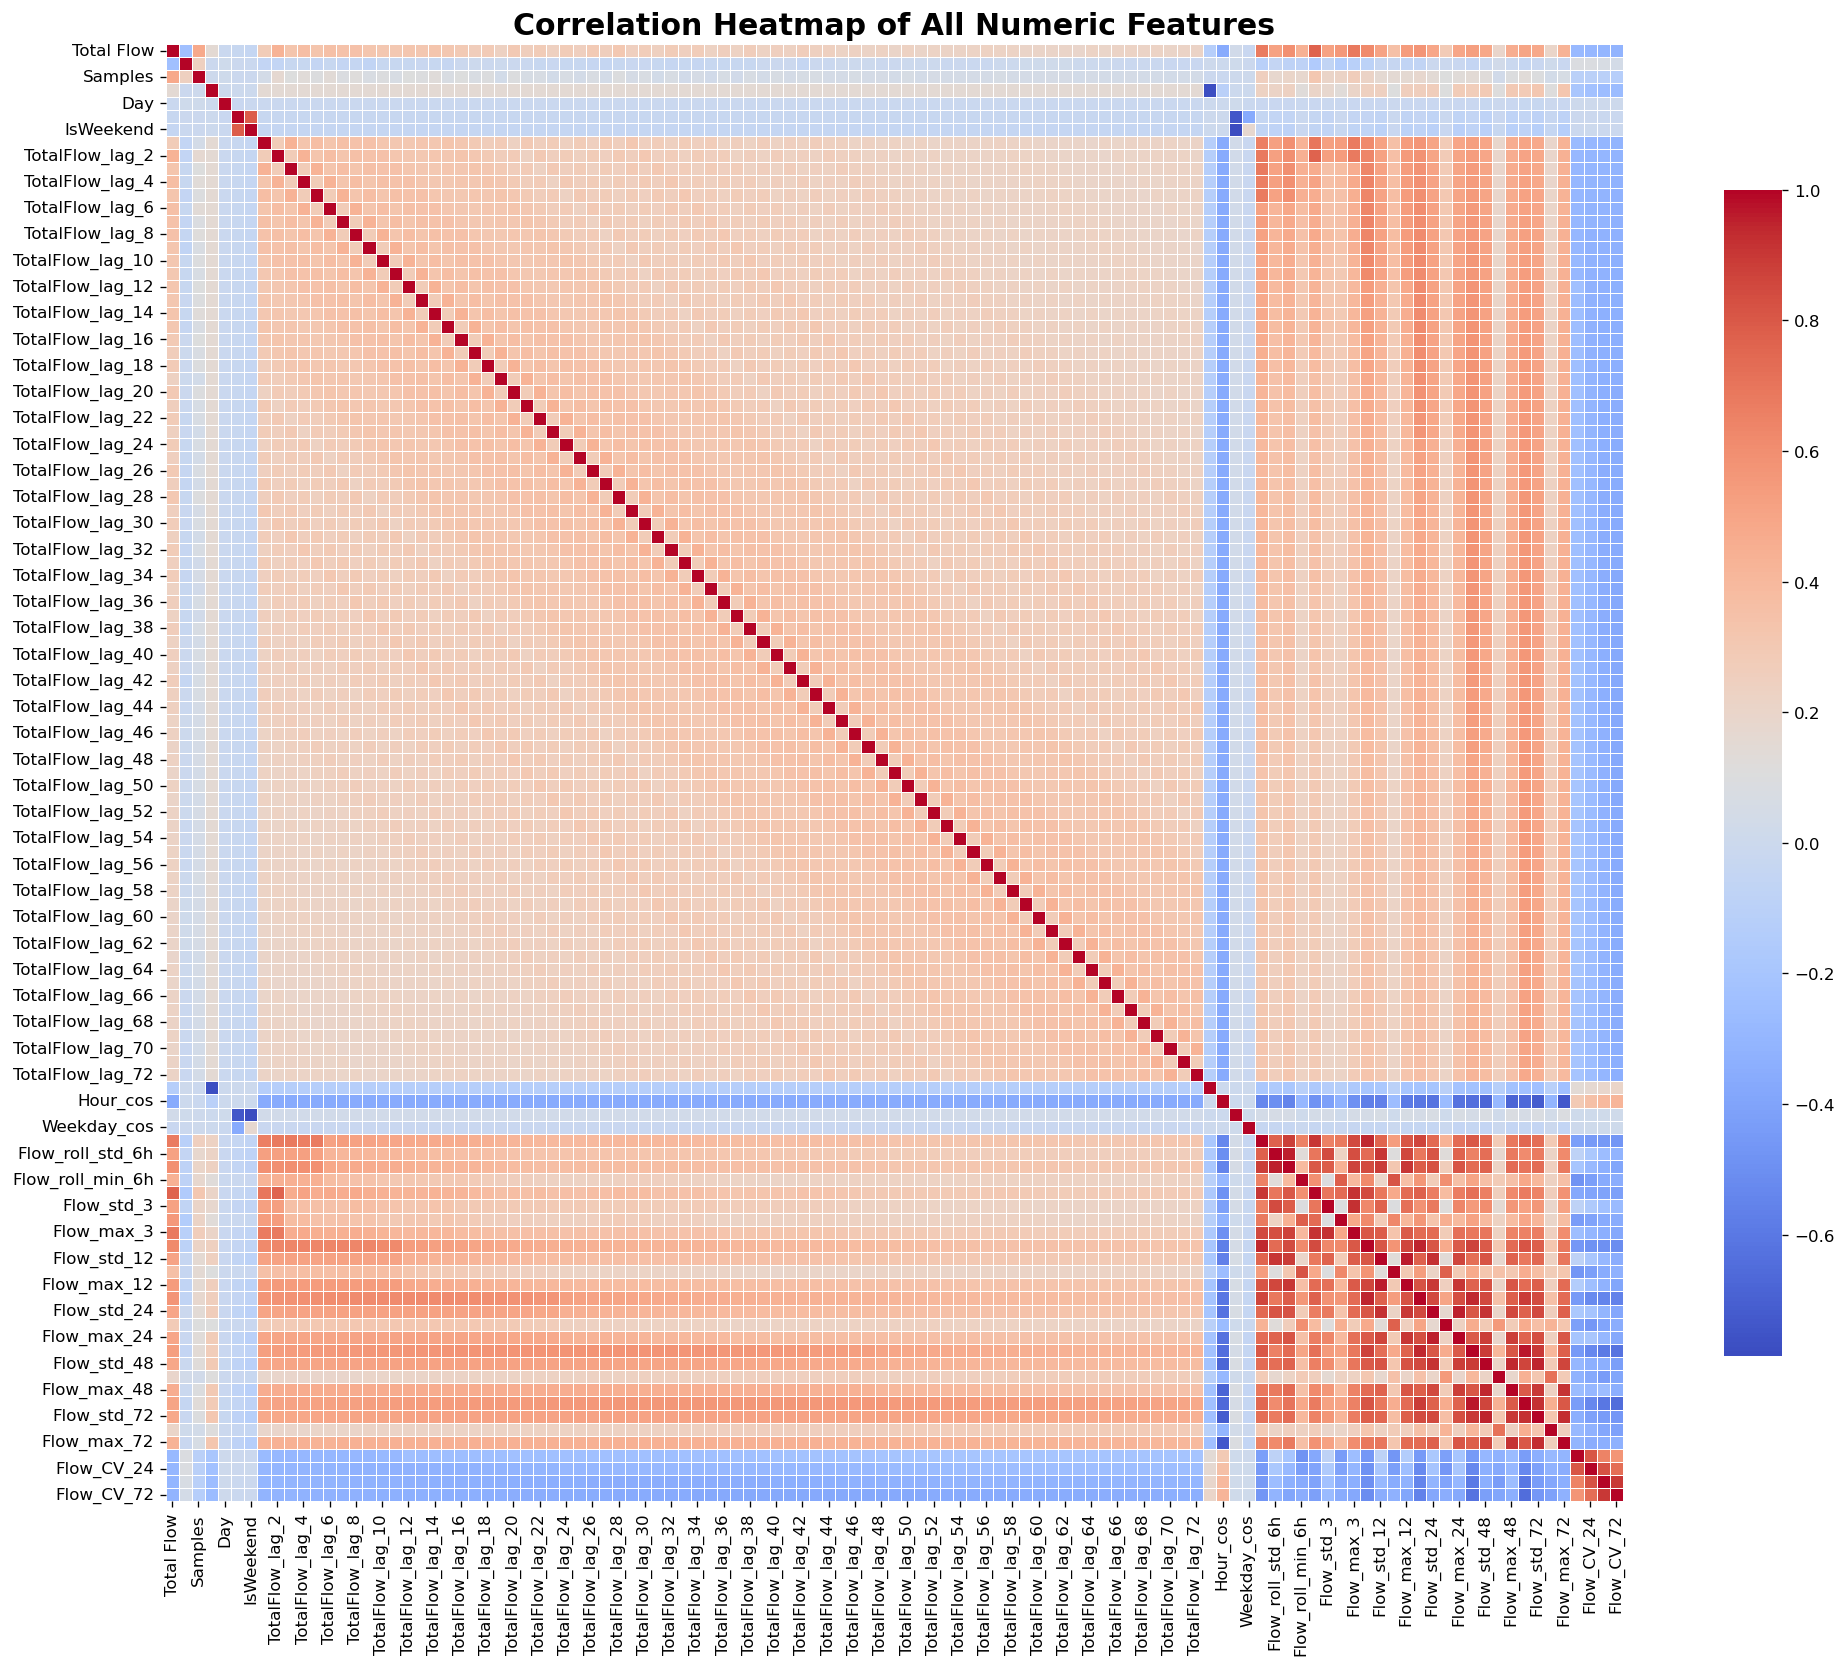

In [39]:
# Plot full correlation matrix
plt.figure(figsize=(18, 14), dpi=120)
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f",
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap of All Numeric Features", fontsize=18, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

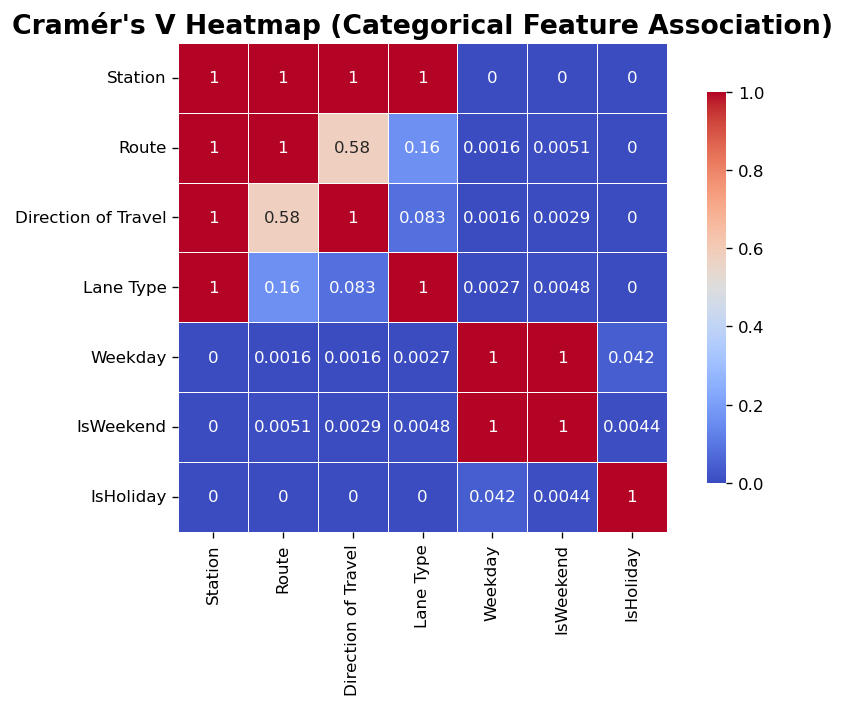

In [40]:
# Function to compute Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of your categorical variables
cat_vars = ['Station', 'Route', 'Direction of Travel', 'Lane Type', 'Weekday', "IsWeekend", "IsHoliday"]

# Create empty matrix
cramers_results = pd.DataFrame(index=cat_vars, columns=cat_vars)

# Compute Cramér’s V for each pair
for col1 in cat_vars:
    for col2 in cat_vars:
        cramers_results.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert to numeric matrix
cramers_results = cramers_results.astype(float)

# Plot heatmap
plt.figure(figsize=(8, 6), dpi=120)
sns.heatmap(cramers_results, annot=True, cmap='coolwarm', vmin=0, vmax=1, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Heatmap (Categorical Feature Association)", fontsize=16, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [41]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [42]:
# Define target and features
target = 'Total Flow'
features = [col for col in df.columns if col != target]

In [43]:
# Split the data
X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define datasets
train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
val_set = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_set)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

# Train with callback for early stopping
model = lgb.train(
    params,
    train_set,
    num_boost_round=100,
    valid_sets=[train_set, val_set],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 105.061	valid_1's rmse: 106.529


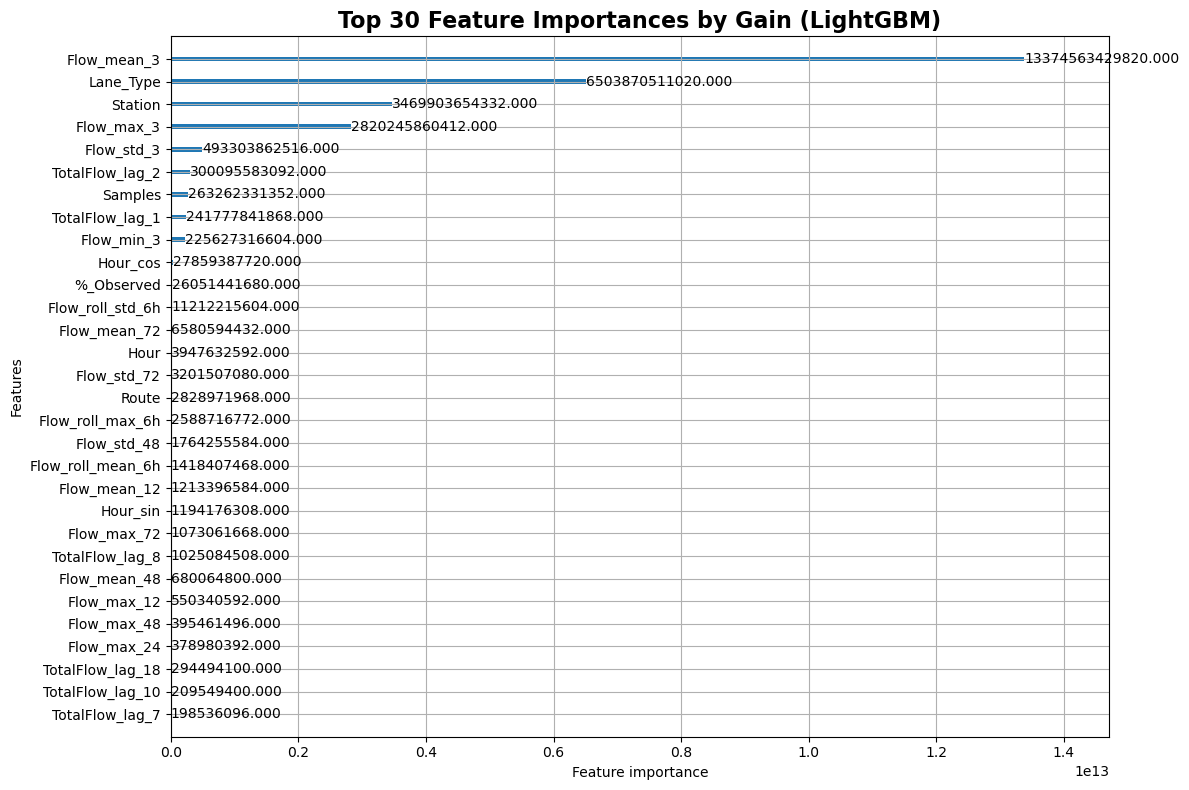

In [44]:
# Plot Feature Importance
lgb.plot_importance(model, max_num_features=30, importance_type='gain', figsize=(12, 8))
plt.title("Top 30 Feature Importances by Gain (LightGBM)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [45]:
# Final feature groups
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48',
    'Flow_roll_std_6h', 'Flow_roll_max_6h',
    'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8',
    'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = [
    'Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos'
]

quality_features = [
    'Samples', '% Observed'
]

# Copy original DataFrame
df_model = df.copy()

# One-hot encode low-cardinality features
df_model = pd.get_dummies(df_model, columns=['IsHoliday', 'Direction of Travel'], drop_first=True)

# Label encode high-cardinality categorical features
for col in ['Station', 'Route', 'Lane Type']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Capture dummy columns dynamically
dummy_columns = [col for col in df_model.columns if col.startswith('IsHoliday_') or col.startswith('Direction of Travel_')]

# Final feature list
categorical_features = ['Lane Type', 'Route', 'Station']
selected_features = flow_features + lag_features + time_features + quality_features + categorical_features + dummy_columns


In [46]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

def evaluate_baseline_linear_model(df, selected_features, forecast_horizons=[12, 24, 48, 72]):
    results = []

    for horizon in forecast_horizons:
        target = f'TotalFlow_lag_{horizon}'
        df_model = df.dropna(subset=[target] + selected_features)

        X = df_model[selected_features]
        y = df_model[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        results.append({
            'Horizon': f'{horizon} hours',
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2)
        })

    return pd.DataFrame(results)

In [47]:
baseline_results = evaluate_baseline_linear_model(df_model, selected_features)
print("Linear Regression Baseline Results:")
print(baseline_results)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

Linear Regression Baseline Results:
    Horizon     MAE     RMSE  MAPE (%)
0  12 hours  696.04  1027.22    904.75
1  24 hours  724.70  1062.04    977.09
2  48 hours  732.64  1069.39   1033.49
3  72 hours  778.93  1120.21   1162.42



 Diagnostics for 12-hour Horizon


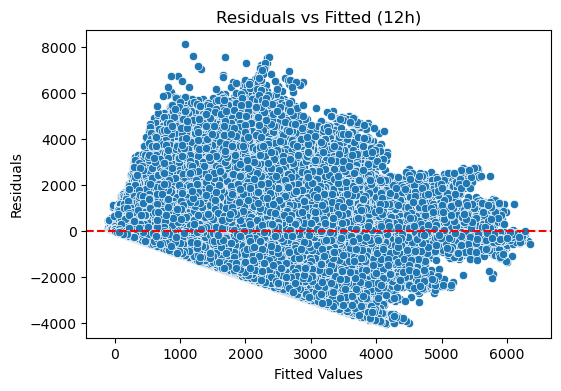

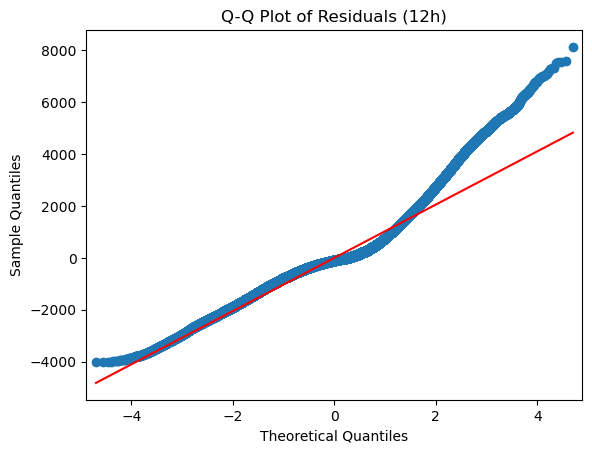

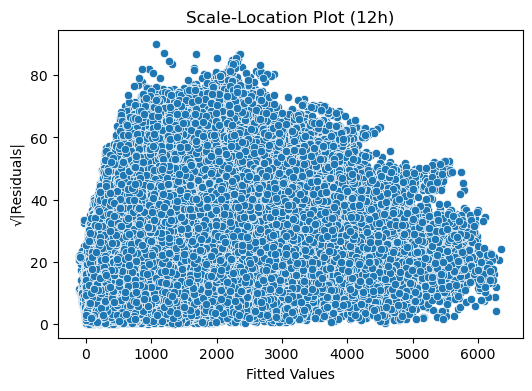

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---- Run diagnostics across forecast horizons ----
forecast_horizons = [12, 24, 48, 72]

for horizon in forecast_horizons:
    print(f"\n Diagnostics for {horizon}-hour Horizon")

    target = f'TotalFlow_lag_{horizon}'
    df_diag = df_model.dropna(subset=[target] + selected_features)

    X = df_diag[selected_features]
    y = df_diag[target]

    # Use same split as original model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    # 1. Residuals vs Fitted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Fitted ({horizon}h)')
    plt.show()

    # 2. Q-Q Plot
    qqplot(residuals, line='s')
    plt.title(f'Q-Q Plot of Residuals ({horizon}h)')
    plt.show()

    # 3. Scale-Location Plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
    plt.xlabel('Fitted Values')
    plt.ylabel('√|Residuals|')
    plt.title(f'Scale-Location Plot ({horizon}h)')
    plt.show()

    # 4. Residuals vs Leverage (with safe float conversion)
    X_train_const = sm.add_constant(X_train).astype(float)
    y_train_numeric = y_train.astype(float)

    sm_model = sm.OLS(y_train_numeric, X_train_const).fit()
    sm.graphics.influence_plot(sm_model, criterion="cooks", size=2)
    plt.title(f'Residuals vs Leverage ({horizon}h)')
    plt.show()

    # 5. VIF Table
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values.astype(float), i) for i in range(X.shape[1])]

    print(f" Variance Inflation Factors (VIF) for {horizon}h:")
    display(vif_data.sort_values(by='VIF', ascending=False))


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def evaluate_random_forest_model(df, selected_features, forecast_horizons=[12, 24, 48, 72]):
    results = []

    for horizon in forecast_horizons:
        target = f'TotalFlow_lag_{horizon}'
        df_model = df.dropna(subset=[target] + selected_features)

        X = df_model[selected_features]
        y = df_model[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        results.append({
            'Horizon': f'{horizon} hours',
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE (%)': round(mape, 2)
        })

    return pd.DataFrame(results)

In [ ]:
rf_results = evaluate_random_forest_model(df_model, selected_features)
print("Random Forest Results:")
print(rf_results)